In [1]:
#Main information source: https://agromonitoring.com/api/polygons
import json
import requests
import geojson
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

token = 'd71223f2476a9229b9670a19065fd55c'

# Create a polygon

In [2]:
#Fill out your polygon coordinates here
geometry = {"type":"Polygon","coordinates":[[[-0.48786,39.63892],[-0.48786,39.66084],[-0.44512,39.66084],[-0.44512,39.63892],[-0.48786,39.63892]]]}

In [3]:
# This call will create a polygon on my user account on agro API. The free account limit is 1000 ha. 
# Largest possible area is 3000 ha per polygon. 
response_creation = requests.post(
    url = f'http://api.agromonitoring.com/agro/1.0/polygons?appid={token}',
    headers={'Content-Type': 'application/json'},
    json = {
            'name': 'TestPolygon',
            'appid': 'd71223f2476a9229b9670a19065fd55c',
            'geo_json':{
                'type': 'FeatureCollection',
                'features':[
                    {'type':'Feature',
                        'properties':{},
                        'geometry': geometry
                    }
                ]
            }
        }
)

In [4]:
response_creation = requests.get(
    url = f'http://api.agromonitoring.com/agro/1.0/polygons?appid={token}')

In [5]:
response_creation.json()

[{'id': '605867e464262200075df5a9',
  'geo_json': {'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-121.1958, 37.6683],
      [-121.1779, 37.6687],
      [-121.1773, 37.6792],
      [-121.1958, 37.6792],
      [-121.1958, 37.6683]]]}},
  'name': 'Default',
  'center': [-121.1867, 37.6739],
  'area': 190.6343,
  'user_id': '605867e464262200075df5a6',
  'created_at': 1616406500},
 {'id': '6058c083bddeaf5effbbeffe',
  'geo_json': {'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[8.31989, 47.285621],
      [8.32092, 47.283003],
      [8.322058, 47.283832],
      [8.323474, 47.284225],
      [8.325448, 47.284443],
      [8.32356, 47.286872],
      [8.31989, 47.285621]]]}},
  'name': 'TestPolygon',
  'center': [8.322558333333333, 47.284665999999994],
  'area': 9.26,
  'user_id': '605867e464262200075df5a6',
  'created_at': 1616429187},
 {'id': '6059be4389177074678eda48',
  'geo_json': {'type': 'Fe

# Search for satellite data in the selected polygon

In [6]:
from datetime import datetime
from datetime import timezone

In [7]:
polygonID = '6059be4389177074678eda48'

#Start date of the data search (unix time, UTC)
start = datetime(2018, 10, 19, tzinfo=timezone.utc).timestamp()

#End date of the data search (unix time, UTC)
end = datetime(2020, 10, 19, tzinfo=timezone.utc).timestamp()



In [8]:
property = 'mean'

In [9]:
#Here you can select further parameters, such as satellite, resolution, etc. (https://agromonitoring.com/api/images)
response = requests.get(
    url = f'http://api.agromonitoring.com/agro/1.0/image/search?start={start}&end={end}&polyid={polygonID}&appid={token}'
)

In [10]:
response2 = requests.get(url = response.json()[0]['stats']['ndvi'])

In [11]:
#Retrieve the time of each data collection
time_points = [datetime.utcfromtimestamp(t1['dt']) for t1 in response.json()]

In [12]:
#mean_ndvi_points = [requests.get(url = elem['stats']['ndvi']).json()[property] for elem in response.json() if property in requests.get(url = elem['stats']['ndvi']).json()]

In [13]:
#Retrieve the statistical values
ndvi_points2 = pd.DataFrame()
for ind in range(0,len(response.json())):
    response2 = requests.get(url = response.json()[ind]['stats']['ndvi'])
    if 'mean' in response2.json():
        ndvi_points2 = ndvi_points2.append([response2.json()[property]])
    else:
        ndvi_points2 = ndvi_points2.append([np.nan])


In [15]:
data1 ={'Year-Month-Day': time_points, 
        f'{property} NDVI': ndvi_points2[0] }
df = pd.DataFrame(data=data1)

In [16]:
df

,Year-Month-Day,mean NDVI
0,2018-10-21,0.325078
0,2018-10-23,0.139066
0,2018-10-28,0.093728
0,2018-10-30,0.068104
0,2018-11-02,0.107731
...,...,...
0,2020-10-07,0.185474
0,2020-10-10,0.043625
0,2020-10-12,0.382827
0,2020-10-17,0.367409


In [17]:
#Font for plot
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

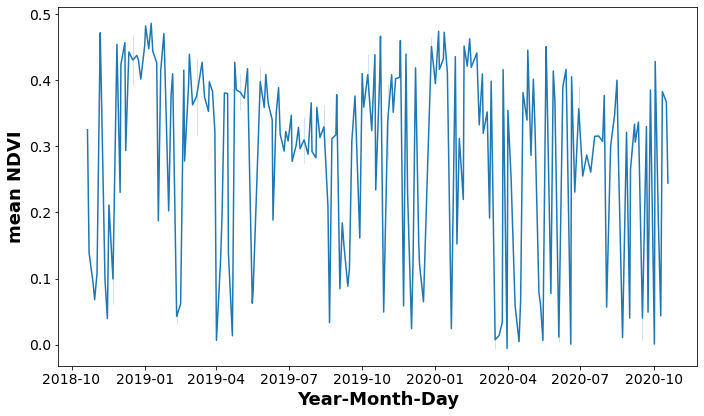

In [18]:
plt.figure(figsize=(10,6))
g = sns.lineplot(data=df, x='Year-Month-Day', y=f'{property} NDVI', markers=True, dashes=False)

g.set_xlabel('Year-Month-Day', fontweight='bold', fontsize=18)
g.set_ylabel(f'{property} NDVI', fontweight='bold', fontsize=18)

# labels appear outside of plot area, so auto-adjust
plt.tight_layout()

In [19]:
response.json()[3]['tile']['ndvi']

'http://api.agromonitoring.com/tile/1.0/{z}/{x}/{y}/0205bd79f00/6059be4389177074678eda48?appid=d71223f2476a9229b9670a19065fd55c'

# Soil data

In [20]:
#Current soil data is available for free accounts. Historical data is not. However, a user can log current data.
response = requests.get(
    url = f'http://api.agromonitoring.com/agro/1.0/soil?polyid={polygonID}&appid={token}')

In [21]:
#Response is with 'dt' = timestamp, 't10' = Temperature in Kelvin 10 cm below surface, 
#'moisture' = soil moisture in m3/m3, 't0' = Surface Temperature in Kelvin
response.json()

{'dt': 1616457600, 't10': 283.966, 'moisture': 0.122, 't0': 278.093}